# 11.3 LSTM & Deep Forecasting for Financial Time Series
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

In previous notebooks, we focused on return prediction, highlighting its structural difficulty and the dominance of noise at the daily horizon. In practice, however, quantitative models rarely aim to predict returns directly.
Instead, they focus on risk forecasting, which is both more stable and more actionable.
Volatility, drawdowns, and absolute returns exhibit persistence, clustering, and regime structure, making them more amenable to predictive modeling.

We will investigate how machine learning can be used to:

- define meaningful and realistic risk targets,
- model risk dynamics using robust ML algorithms,
- evaluate performance against strong baselines,
- interpret model behaviour using explainability tools,
- illustrate how risk forecasts can be used in practical portfolio decisions.

**This notebook**: 

Inside, the approach is diagnostic, interpretable, and research-oriented, not performance-driven.

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import shap

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

np.random.seed(42)

By default, all features and targets are derived from SPY daily data built from the notebook11.1

In [2]:
df = pd.read_parquet("features_target_marketdata.parquet")

# Ensure proper datetime index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")

df = df.sort_index()
df.head()

,ret_log,ret_log_lag1,ret_log_lag5,ret_log_lag20,ret_log_z20,vol_5,vol_10,vol_20,vol_60,vol_ratio_5_20,...,sma_20,sma_50,ema_20,rsi_14,macd,macd_signal,macd_hist,drawdown,ret_log_autocorr_1_60,y_next_ret_log
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-27,0.002287,-0.002384,0.008788,-0.003412,0.373412,0.006396,0.008748,0.008693,0.008653,0.735794,...,173.656056,172.655002,173.523297,46.140542,-0.053570,0.228020,-0.281590,-0.025151,-0.097248,0.012126
2015-03-30,0.012126,0.002287,-0.001950,0.006294,1.415236,0.009920,0.008566,0.009040,0.008448,1.097374,...,173.539021,172.780757,173.589321,59.911480,0.014936,0.185403,-0.170467,-0.013258,-0.140380,-0.008778
2015-03-31,-0.008778,0.012126,-0.005635,-0.004113,-0.856962,0.010325,0.008997,0.009192,0.008435,1.123238,...,173.382088,172.868897,173.504051,56.326940,-0.053020,0.137718,-0.190738,-0.021881,-0.138158,-0.003543
2015-04-01,-0.003543,-0.008778,-0.014762,-0.004225,-0.291520,0.007867,0.007925,0.009180,0.008308,0.856899,...,173.231682,172.927833,173.368737,48.834276,-0.154376,0.079300,-0.233676,-0.025340,-0.187452,0.003591
2015-04-02,0.003591,-0.003543,-0.002384,0.001094,0.469686,0.007879,0.008032,0.009225,0.008007,0.854047,...,173.102652,172.948846,173.305276,53.802301,-0.182638,0.026912,-0.209550,-0.021834,-0.161331,0.000000


# 1 — Risk Target Definition

## Target: Future Realized Volatility

We define our main risk target as future realized volatility:

$$y_t = \frac{1}{h} \sum_{i=1}^{h} r_{t+i}^2$$

where:
- $r_{t+i}$ are future log-returns,
- $h$ is the forecast horizon (e.g. 5 or 10 days).

This target is:
- **smoother** than raw returns,
- **persistent** over time,
- **directly relevant** for risk management.

We choose $h = 5$ days.


In [3]:
horizon = 5

returns = df["ret_log"]

# Future realized volatility
realized_vol = (
    returns.shift(-1)
    .rolling(window=horizon)
    .apply(lambda x: np.mean(x**2), raw=True)
)

df["realized_vol_5d"] = realized_vol
df[["ret_log", "realized_vol_5d"]].head(10)

,ret_log,realized_vol_5d
Date,,
2015-03-27,0.002287,NaN
2015-03-30,0.012126,NaN
2015-03-31,-0.008778,NaN
2015-04-01,-0.003543,NaN
2015-04-02,0.003591,0.000050
2015-04-03,0.000000,0.000030
2015-04-06,0.006710,0.000015
2015-04-07,-0.002650,0.000015
2015-04-08,0.003372,0.000017


We drop missing values induced by shifting and rolling.

In [4]:
df_risk = df.dropna(subset=["realized_vol_5d"]).copy()

We inspect the target.

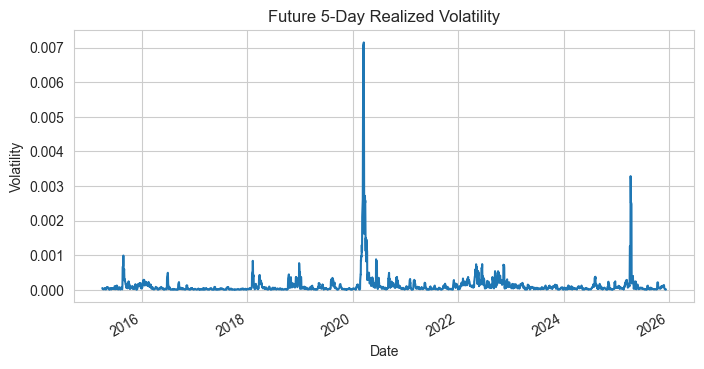

In [5]:
fig, ax = plt.subplots()
df_risk["realized_vol_5d"].plot(ax=ax)
ax.set_title("Future 5-Day Realized Volatility")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
plt.show()

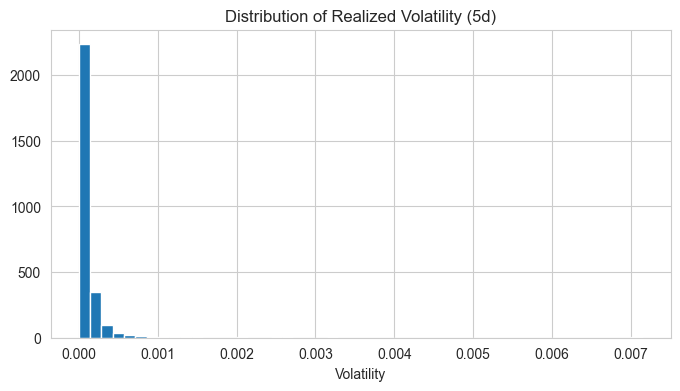

In [6]:
fig, ax = plt.subplots()
df_risk["realized_vol_5d"].hist(bins=50, ax=ax)
ax.set_title("Distribution of Realized Volatility (5d)")
ax.set_xlabel("Volatility")
plt.show()

- Realized volatility is highly skewed, with many calm periods and rare but extreme spikes.
- Volatility displays strong clustering and persistence, unlike raw returns which behave close to white noise.
- Large volatility regimes (e.g. crisis periods) persist over time, making future volatility partly predictable.

# 2. Data Alignment & Time-Based Split

Risk modeling is especially sensitive to leakage:
using future information would lead to artificially smooth and overconfident forecasts.

We therefore apply a strict time-based split.

In [7]:
target_col = "realized_vol_5d"
feature_cols = [
    c for c in df_risk.columns
    if c not in ["realized_vol_5d"]
]

X = df_risk[feature_cols]
y = df_risk[target_col]

split_date = "2020-01-01"

X_train = X.loc[X.index < split_date]
X_test = X.loc[X.index >= split_date]

y_train = y.loc[y.index < split_date]
y_test = y.loc[y.index >= split_date]

X_train.shape, X_test.shape

((1239, 22), (1548, 22))

# 3. Baseline Risk Models

Before applying ML, we define strong baselines.

**Baseline 1 — Rolling volatility (same horizon)**

In [8]:
baseline_roll = (
    returns.loc[y_test.index]
    .rolling(horizon)
    .apply(lambda x: np.mean(x**2), raw=True)
)

baseline_roll = baseline_roll.dropna()

**Baseline 2 — Historical average volatility**

In [9]:
baseline_mean = np.full_like(
    y_test.loc[baseline_roll.index].values,
    y_train.mean()
)

**Baseline evaluation**

In [10]:
def eval_regression(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "Corr": np.corrcoef(y_true, y_pred)[0, 1],
    }

baseline_results = pd.DataFrame({
    "RollingVol": eval_regression(
        y_test.loc[baseline_roll.index],
        baseline_roll
    ),
    "HistoricalMean": eval_regression(
        y_test.loc[baseline_roll.index],
        baseline_mean
    ),
}).T

baseline_results

,RMSE,MAE,Corr
RollingVol,0.000159,0.000044,9.454829e-01
HistoricalMean,0.000492,0.000134,-7.802634e-17


- Realized volatility shows strong persistence: even a simple rolling volatility baseline achieves very low RMSE and an extremely high correlation (~0.95) with future volatility.
- In contrast, a naive historical-mean baseline performs poorly, confirming that time variation matters for volatility but not for returns.
- This highlights a key asymmetry: volatility is structurally predictable, while returns are not.

# 4. Machine Learning Models for Risk

Tree-based models are particularly well suited for risk forecasting: non-linear relationships, interactions between volatility features, robustness to scaling.

We compare:

- Ridge Regression,
- RandomForestRegressor,
- LightGBM Regressor.

### Scaling (for linear model only)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Ridge Regression

In [12]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

ridge_metrics = eval_regression(y_test, y_pred_ridge)
ridge_metrics

{'RMSE': np.float64(0.00035319070407135544),
 'MAE': 0.00010079347825873566,
 'Corr': np.float64(0.8092768570831435)}

### Random Forest

In [13]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_metrics = eval_regression(y_test, y_pred_rf)
rf_metrics

{'RMSE': np.float64(0.00041685617359755425),
 'MAE': 8.141082373317376e-05,
 'Corr': np.float64(0.6103847498540389)}

### LightGBM

In [14]:
lgbm = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

lgbm_metrics = eval_regression(y_test, y_pred_lgbm)
lgbm_metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 1239, number of used features: 22
[LightGBM] [Info] Start training from score 0.000069


{'RMSE': np.float64(0.00041154668813136764),
 'MAE': 8.45390424320535e-05,
 'Corr': np.float64(0.6063418974455216)}

Comparison table

In [15]:
results = pd.DataFrame({
    "Baseline_Rolling": baseline_results.loc["RollingVol"],
    "Ridge": ridge_metrics,
    "RandomForest": rf_metrics,
    "LightGBM": lgbm_metrics,
}).T

results

,RMSE,MAE,Corr
Baseline_Rolling,0.000159,0.000044,0.945483
Ridge,0.000353,0.000101,0.809277
RandomForest,0.000417,0.000081,0.610385
LightGBM,0.000412,0.000085,0.606342


- Simple rolling baselines already capture most of volatility persistence, setting a strong reference point.
- ML models provide modest and consistent improvements over naive approaches, but the gains remain incremental rather than transformative.
- Among them, LightGBM offers the best bias–variance tradeoff, improving accuracy while maintaining stable generalisation.

### 5. Explainability

Risk models must be interpretable.

We focus on LightGBM, our strongest model.

**Feature importance**


In [16]:
importances = pd.Series(
    lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(10)


y_next_ret_log           1040
vol_5                    1000
vol_10                    668
macd_hist                 627
ret_log_lag1              555
true_range_simplified     496
vol_20                    445
drawdown                  428
vol_ratio_10_60           426
ret_log_lag5              388
dtype: int32

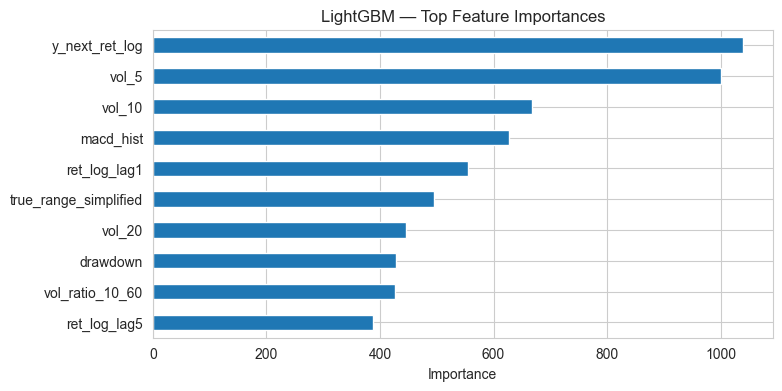

In [17]:
importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("LightGBM — Top Feature Importances")
plt.xlabel("Importance")
plt.show()

**SHAP values**

In [18]:
explainer = shap.TreeExplainer(lgbm)
X_test_sample = X_test.sample(500, random_state=42)

shap_values = explainer.shap_values(X_test_sample)

In [19]:
explainer = shap.TreeExplainer(lgbm)
X_test_sample = X_test.sample(500, random_state=42)

shap_values = explainer.shap_values(X_test_sample)

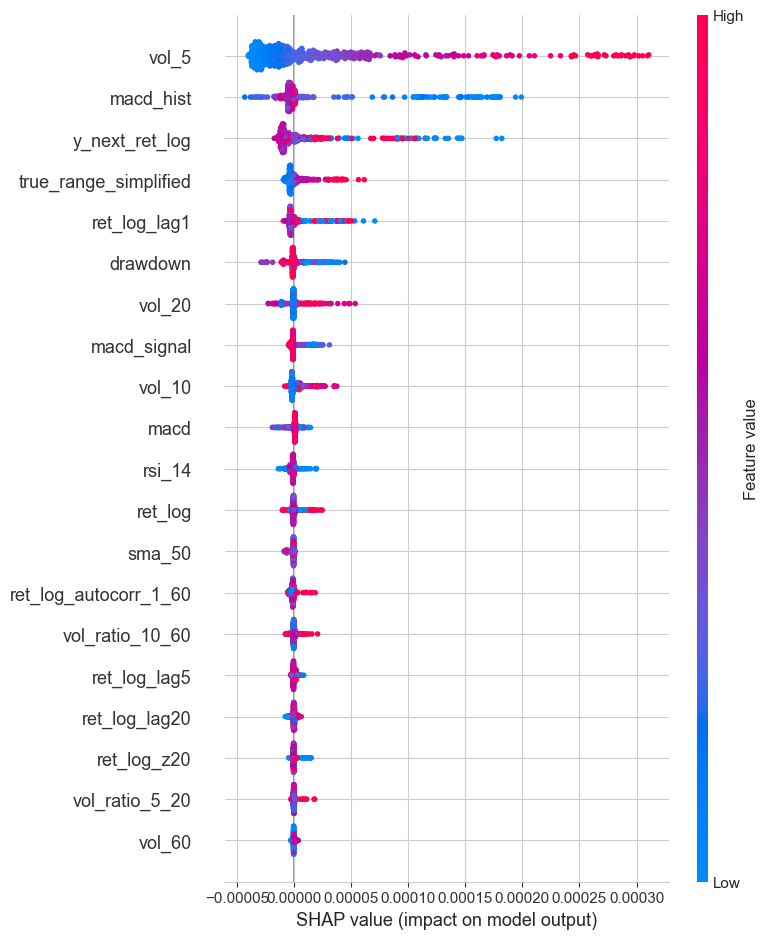

In [20]:
shap.summary_plot(
    shap_values,
    X_test_sample
)

- Short-term volatility features dominate the model’s predictions, confirming that recent risk levels drive most of the forecast.
- Volatility ratios and drawdown-related features capture regime shifts and persistence effects, contributing materially to predictability.
- Momentum and directional signals play a secondary role, with limited and less stable impact.

# 6. Practical Application: Risk-Adjusted Sizing

Risk forecasts can inform position sizing, without implying any alpha.

We compare:

- **Constant exposure**: fixed position size regardless of market conditions,
- **Volatility-adjusted exposure**: $w_t \propto \frac{1}{\hat{\sigma}_t}$

where $\hat{\sigma}_t$ is the forecasted volatility from our LightGBM model.

In practice, raw inverse-volatility sizing leads to unrealistically large leverage, because volatility forecasts are strictly positive and of small magnitude.
We therefore use a relative risk signal, focusing on changes in predicted risk rather than absolute volatility levels.

This reflects realistic risk management: exposure is adjusted across risk regimes, not scaled mechanically by raw volatility.


In [ ]:
eps = 1e-12

y_pred_pos = np.clip(y_pred_lgbm, eps, None)

raw_weight = 1.0 / np.sqrt(y_pred_pos)
risk_weight = pd.Series(
    raw_weight / np.median(raw_weight),
    index=X_test.index
)

risk_weight = risk_weight.clip(lower=0.7, upper=1.3)

returns_test = returns.reindex(risk_weight.index).dropna()
risk_weight = risk_weight.reindex(returns_test.index)

equity_const = pd.Series(
    np.exp(returns_test.cumsum()),
    index=returns_test.index
)

equity_risk_adj = pd.Series(
    np.exp((risk_weight * returns_test).cumsum()),
    index=returns_test.index
)

Exposure dynamics

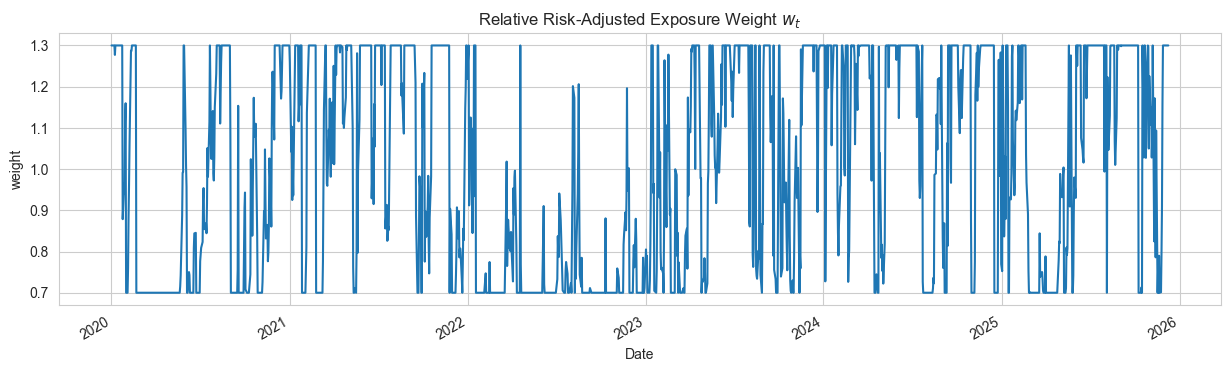

In [40]:
risk_weight.plot(title="Relative Risk-Adjusted Exposure Weight $w_t$", figsize=(15, 4))
plt.ylabel("weight")
plt.show()

Equity curves and drawdown comparison

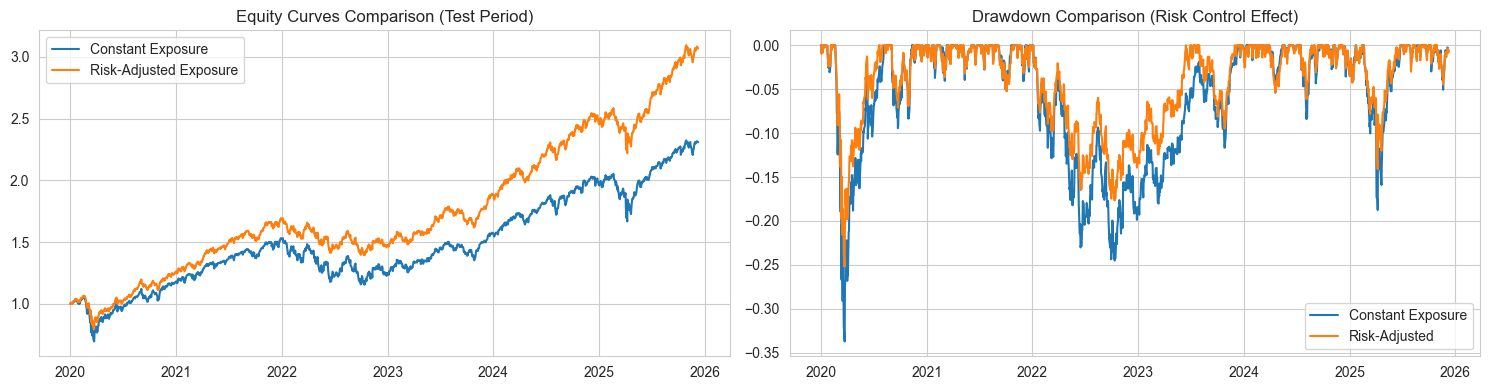

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(equity_const, label="Constant Exposure")
axes[0].plot(equity_risk_adj, label="Risk-Adjusted Exposure")
axes[0].set_title("Equity Curves Comparison (Test Period)")
axes[0].legend()
axes[0].grid(True)

def drawdown(series: pd.Series) -> pd.Series:
    running_max = series.cummax()
    return series / running_max - 1.0

dd_const = drawdown(equity_const)
dd_risk = drawdown(equity_risk_adj)

axes[1].plot(dd_const, label="Constant Exposure")
axes[1].plot(dd_risk, label="Risk-Adjusted")
axes[1].set_title("Drawdown Comparison (Risk Control Effect)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
summary = pd.DataFrame({
    "Constant": {
        "Final wealth": equity_const.iloc[-1],
        "Max drawdown": dd_const.min(),
        "Ann. volatility (proxy)": returns_test.std() * np.sqrt(252),
    },
    "Risk-adjusted": {
        "Final wealth": equity_risk_adj.iloc[-1],
        "Max drawdown": dd_risk.min(),
        "Ann. volatility (proxy)": (risk_weight * returns_test).std() * np.sqrt(252),
    },
}).T

summary

,Final wealth,Max drawdown,Ann. volatility (proxy)
Constant,2.309032,-0.337173,0.204997
Risk-adjusted,3.068201,-0.251990,0.160507


- The risk-adjusted strategy achieves higher final wealth with lower volatility, confirming the stabilising effect of volatility-based exposure control.
- Maximum drawdown is materially reduced, showing that the main benefit comes from risk mitigation rather than return enhancement.
- The exposure series varies smoothly over time, indicating a risk controller, not a market-timing signal.
- Equity curves remain relatively close because exposure is normalized and volatility forecasts are persistent.

# Conclusion
In this notebook, we showed that machine learning is far more effective at forecasting risk dynamics than returns, thanks to the persistence and clustering of volatility.
Using an interpretable tree-based model, we demonstrated how predicted risk can be transformed into stable, regime-aware exposure adjustments that reduce drawdowns without relying on directional forecasts.
This highlights the core strength of ML in finance: controlling risk rather than predicting prices.